In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.utils.data.dataloader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets
import os
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Tuple,Dict,List
from torchinfo import summary
from tqdm.auto import tqdm
from timeit import default_timer as timer
import torchvision
import random
from pathlib import Path

C:\Users\Enes\Desktop\COMPUTER VİSİON\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
#for seperating data to train and test folders
import os
import shutil
import random

# Define the path to your main folder containing the 35 subfolders
main_folder = "FoodClassificationdataset/"

# Define the path to the train and test folders
train_folder = 'train'
test_folder = 'test'

# Percentage of images to be allocated for testing
test_percentage = 20

# Iterate through each subfolder in the main folder
for folder_name in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder_name)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        num_images = len(images)
        num_test_images = int(num_images * (test_percentage / 100))

        # Create train and test folders for the current subfolder
        train_subfolder = os.path.join(train_folder, folder_name)
        test_subfolder = os.path.join(test_folder, folder_name)
        os.makedirs(train_subfolder, exist_ok=True)
        os.makedirs(test_subfolder, exist_ok=True)

        # Randomly select images for the test set
        test_images = random.sample(images, num_test_images)

        # Move images to their respective folders
        for image in images:
            image_path = os.path.join(folder_path, image)
            if image in test_images:
                shutil.move(image_path, os.path.join(test_subfolder, image))
            else:
                shutil.move(image_path, os.path.join(train_subfolder, image))

print("Images separated into train and test sets successfully!")

Images separated into train and test sets successfully!


In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from goingmodular import data_setup
data_path=Path()
train_dir=data_path / "train"
test_dir=data_path / "test"


In [4]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms=weights.transforms()

from goingmodular import data_setup
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                          test_dir=test_dir,
                                                                          train_transforms=auto_transforms,
                                                                          test_transforms=auto_transforms,
                                                                          batch_size=32)

In [5]:
model=torchvision.models.efficientnet_b0(weights=weights)

In [6]:
for param in model.features.parameters():
    param.requires_grad=False

In [7]:
summary(model=model,
       input_size=(1,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [8]:
#we are chainging classifier layer because of diffrences between number of classes
model.classifier=nn.Sequential(
    #dropout function will allow us to more nonlinearity 
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names)
)).to(device)

In [9]:
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)


In [10]:
from goingmodular import engine
from timeit import default_timer as timer
start_time=timer()
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
results=engine.train(model=model.cuda(),
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=5,
                    device=device)
end_time=timer()
print(f"[INFO]Total training time= {end_time-start_time:.3f} seconds")

 20%|████████████████▌                                                                  | 1/5 [02:32<10:11, 152.84s/it]

Epoch:0| train_loss:1.4951|train_acc:0.6243|test_loss:0.9576|test_acc:0.7386


 40%|█████████████████████████████████▏                                                 | 2/5 [05:00<07:29, 149.69s/it]

Epoch:1| train_loss:0.9231|train_acc:0.7410|test_loss:0.8174|test_acc:0.7665


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [07:26<04:55, 147.87s/it]

Epoch:2| train_loss:0.8074|train_acc:0.7668|test_loss:0.7843|test_acc:0.7759


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [10:00<02:30, 150.32s/it]

Epoch:3| train_loss:0.7557|train_acc:0.7761|test_loss:0.7613|test_acc:0.7810


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [12:29<00:00, 149.99s/it]

Epoch:4| train_loss:0.7149|train_acc:0.7859|test_loss:0.7320|test_acc:0.7827
[INFO]Total training time= 750.002 seconds


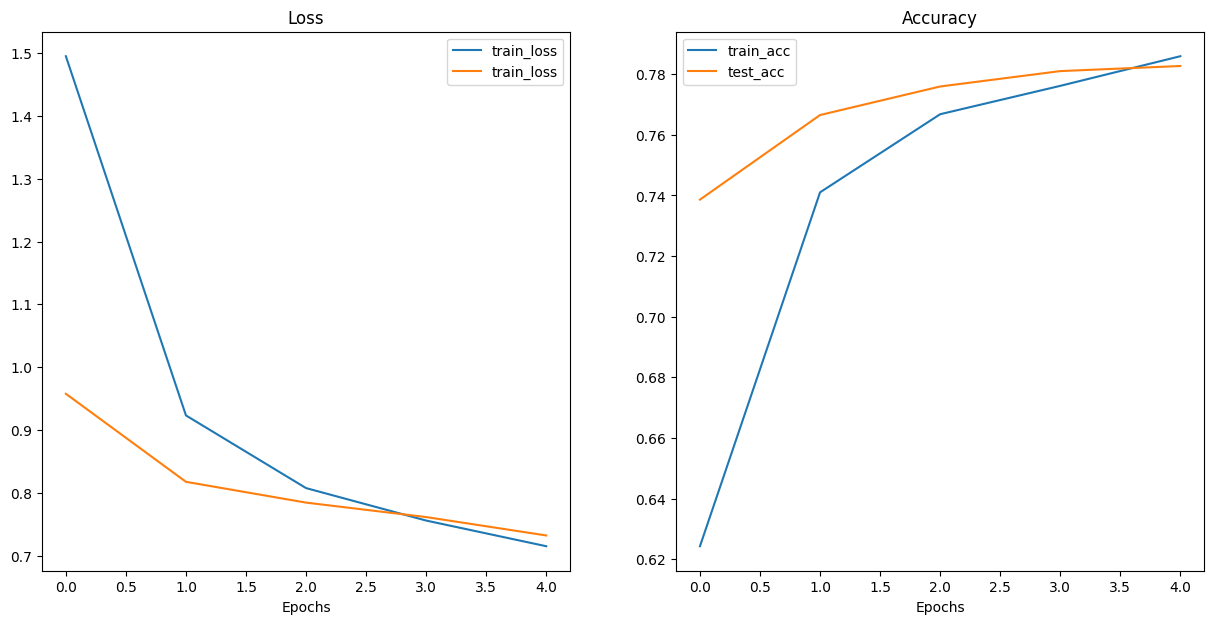

In [14]:
from goingmodular import utils
utils.plot_loss_curves(results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


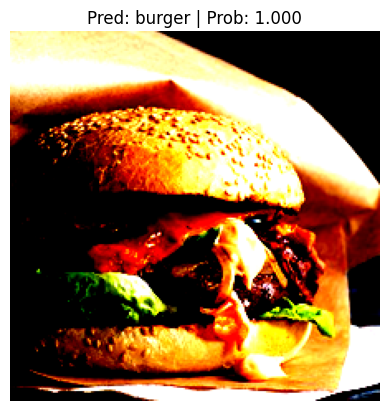

In [15]:
from goingmodular import single_pred
single_pred.pred_and_plot_image(model=model,
                                image_path="burger.jpg",
                                class_names=class_names,
                                transform=auto_transforms,
                                device=device)